# Inverting for geodetic slip rate in 1D

JD Dianala, Oct 2023

*lightly modified from material by Gareth Funning, University of California, Riverside*

In this exercise, we perform a simple inversion for the slip rate of a fault from real GNSS data, making use of an idealized 1D model for elastic deformation around a buried vertical strike-slip fault.

## Contents

0. Dependencies
1. The 1D elastic dislocation model
2. Selecting GNSS stations around a fault
3. Projecting GNSS stations onto a profile
4. Projecting GNSS velocities into the fault-parallel direction
5. Forward 'trial-and-error' models
6. Using a grid search to identify a preferred model
7. References

## 0. Dependencies

This notebook makes use of a few dependencies. Make sure they're all installed before you get started, otherwise Jupyter will be sad...

In [1]:
# import your dependencies
import numpy as np
import utm
import matplotlib.pyplot as plt
import pygmt

## 1. The 1D elastic dislocation model

The analytical model for the 1D velocity profile accross a buried strike-slip fault in an elastic medium was first proposed in the 1960s by Weertman, Chinnery and others, building upon earlier work by Volterra and Steketee. Making a series of simplifying assumptions (the fault is infinitely long, rectangular and vertical, embedded in an elastic half space and extends to infinite depth) made solving for velocities tractable, and the resulting model is very simple and easy to evaluate:

$$v(x) = \left(\frac{s}{\pi}\right)\arctan\left(\frac{x}{D}\right)$$ 

where $v$ is the expected fault-parallel velocity measured a fault-perpendicular distance $x$ from the surface trace of a strike-slip fault with slip rate $s$ and locking depth (depth of burial) $D$. The figure below shows the model geometry: 

<img src="1D_model_setup.png" align=center alt="Diagram of model setup" width="50%">

The formulation is unit-agnostic, but assumes that $s$ and $v$ are in the same units (say, mm/yr), and similarly that $x$ and $D$ are in the same units (say, km). We assume also that the arctangent function outputs angles in radians (the $\pi$ in the denominator should be a clue in that regard...)

This model assumes that the shallow portion of the fault of interest is locked and stationary, but the deep portion is slipping continuously. This continuous deep slip pulls on, and bends the shallow part of the crust, and the distribution of surface deformation rates related to that bending are diagnostic of the slip rate and locking depth.

We can explore the functional form of the deformation rates predicted by the 1D model by evaluating it with a range of different values of $s$ and $D$. 

### 1.1 Initial model

First, let's get started with a fairly simple code (below). Try to get a feel as to what the different parts of the code does:

1. What are the input variables that you can manipulate?
2. Which part of the code is calculating the arctangent function?
3. How does plotting work?

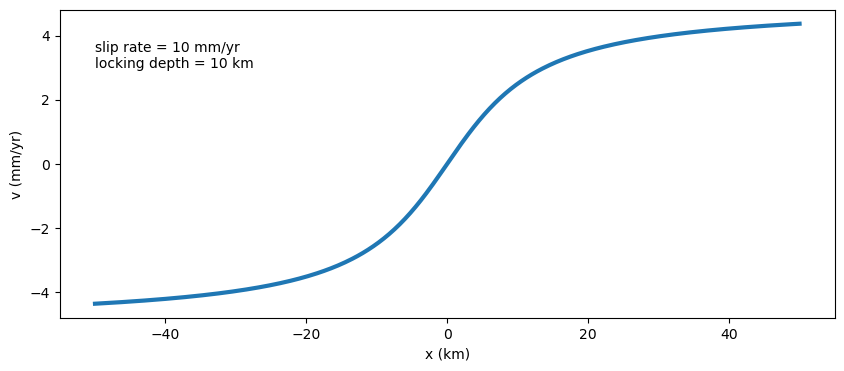

In [2]:
# OK, let's evaluate some arctangents!

# model parameters
D = 10  # locking depth in km
s = 10  # lowest slip rate

# profile parameters
half_length = 50      # profile half length in km
point_spacing = 0.25  # point spacing along profiles in km

# generate the points for the profile
half_points = round(half_length/point_spacing) # how many points along each half of the profile?
x = np.linspace(-half_length,half_length,1+2*half_points)
v = (s/np.pi)*np.arctan(x/D)    # the 1D model!

# initiate the plot
plt.figure(figsize=(10,4))
ax = plt.axes()

## plot the 1D model
plt.plot(x, v, lw=3, label=s)   # plot it as a line of width 3, label with the slip rate
    
# add some labels
plt.xlabel("x (km)")
plt.ylabel("v (mm/yr)")
plt.text(-50, 3., f"slip rate = {s} mm/yr \nlocking depth = {D} km")

plt.show()

<div class="alert alert-warning"><b>Task 1</b><br/>
After running the code above once, play around with different values of locking depth and slip rate. <br/>
Create six (6) different plots: <br/> 
    1. Three plots with the same locking depth (15 km) but different slip rates (10, 20, and 30 mm/yr). <br/>
    2. Three plots with the same slip rate (30 mm/yr) but different locking dephts (2, 5, 10, 15, and 20 km). <br/>
    
Copy these figures to a Word document/Google Doc and describe what happens to the ground deformation signal with smaller and larger slip rates and locking depths.
</div>


##  1.2 Fixed locking depth, varying slip rate
First we can hold $D$ fixed and try a range of values of $s$:

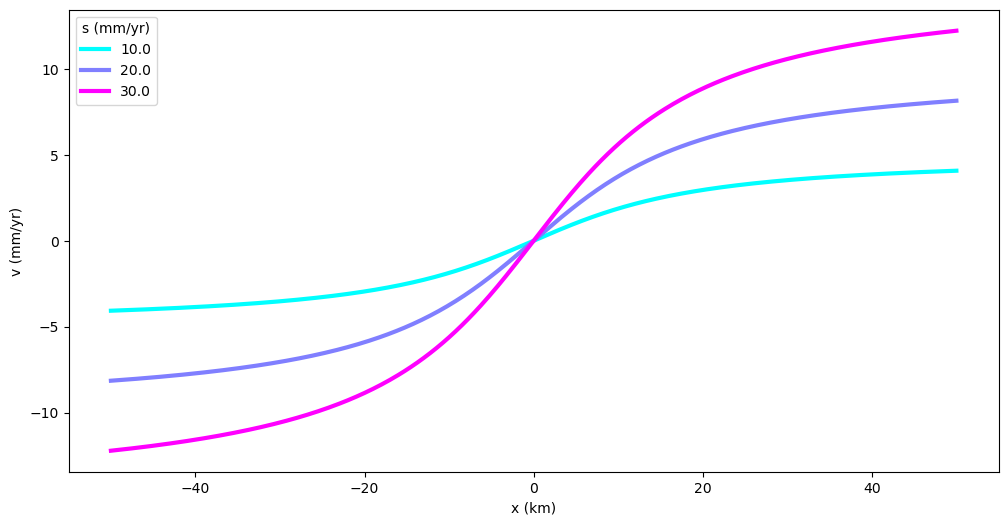

In [3]:
# OK, let's evaluate some arctangents!

# model parameters
D = 15  # locking depth in km
s_min = 10  # lowest slip rate
s_max = 30  # highest slip rate
s_step = 10  # slip rate increment

# profile parameters
half_length = 50      # profile half length in km
point_spacing = 0.25  # point spacing along profiles in km

# generate the points for the profile
half_points = round(half_length/point_spacing) # how many points along each half of the profile?
x = np.linspace(-half_length,half_length,1+2*half_points)

# how many models? what values of s?
n_models = round(1+(s_max-s_min)/s_step)
s_set = np.linspace(s_min,s_max,n_models)

# initiate the plot
plt.figure(figsize=(12,6))

# set some different colors ('cool' ones)
ax = plt.axes()
ax.set_prop_cycle('color',[plt.cm.cool(i) for i in np.linspace(0, 1, n_models)])

# loop through yer values of s
for s in s_set:
    v = (s/np.pi)*np.arctan(x/D)    # the 1D model!
    plt.plot(x, v, lw=3, label=s)   # plot it as a line of width 3, label with the slip rate
    
# add some labels
plt.xlabel("x (km)")
plt.ylabel("v (mm/yr)")
leg = plt.legend(loc=2)             # add a legend, top left
leg.set_title('s (mm/yr)')

plt.show()

The effect of varying $s$, as you can see, is to vary the scale of the deformation signal, i.e. to stretch or shrink the profile in the y axis direction. (You could probably have anticipated this, given that $s$ is a multiplier of the arctangent function in the model!)

The effect of varying $D$ is a little less straightforward, as it is not a linear parameter (it is within the arctangent function), as we shall see... 

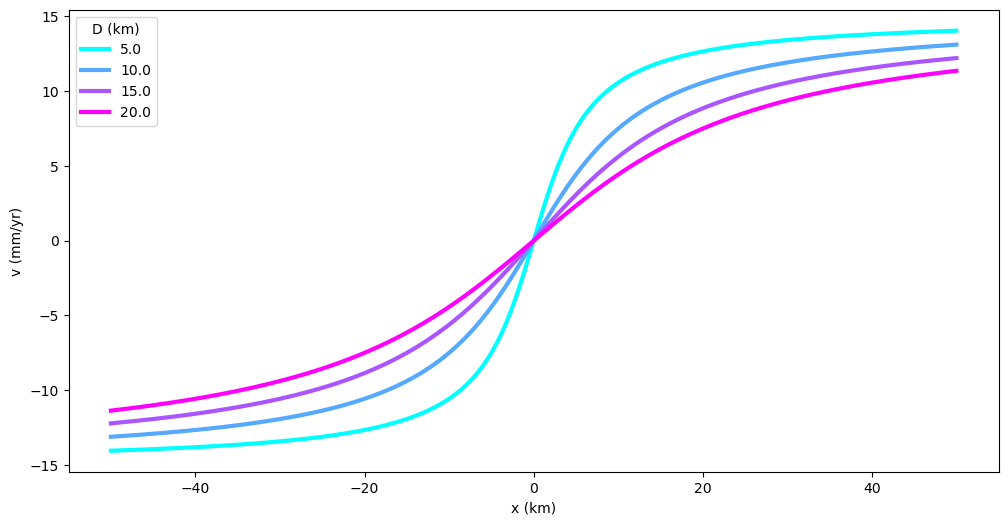

In [4]:
# Evaluate more arctangents!

# model parameters
s = 30      # slip rate in mm/yr
D_min = 5  # shallowest locking depth
D_max = 20  # deepest locking depth
D_step = 5  # locking depth increment

# profile parameters
half_length = 50      # profile half length in km
point_spacing = 0.25  # point spacing along profiles in km

# generate the points for the profile
half_points = round(half_length/point_spacing) # how many points along each half of the profile?
x = np.linspace(-half_length,half_length,1+2*half_points)

# how many models? what values of s?
n_models = round(1+(D_max-D_min)/D_step)
D_set = np.linspace(D_min,D_max,n_models)

# initiate the plot
plt.figure(figsize=(12,6))

# set some different colors ('cool' ones)
ax = plt.axes()
ax.set_prop_cycle('color',[plt.cm.cool(i) for i in np.linspace(0, 1, n_models)])

# loop through yer values of s
for D in D_set:
    v = (s/np.pi)*np.arctan(x/D)    # the 1D model!
    plt.plot(x, v, lw=3, label=D)   # plot it as a line of width 3, label with the locking depth
    
# add some labels
plt.xlabel("x (km)")
plt.ylabel("v (mm/yr)")
leg = plt.legend(loc=2)             # add a legend, top left
leg.set_title('D (km)')

plt.show()

As you see, changing the locking depth changes the gradient of the velocity profile in the vicinity of the fault ($x=0$), in effect sharpening or smearing out the localization of the transition between negative and positive velocities. As $D$ decreases, the profiles tend towards a step function (try setting D_min to zero, brave the numerical errors, and see what you get!) 

## 2. Selecting GNSS stations around a fault

In a classic paper, Savage and Burford (1973) applied the 1D model to fault-parallel velocities, estimated from trilateration, along the San Andreas fault. Modern GNSS velocity data allow us to do something similar. In this section we will go through the process of downloading and selecting GNSS velocity data in preparation for this type of analysis.

<a href="https://www.unavco.org/" target=new>UNAVCO</a> maintain a continent-wide GNSS network, the <a href="https://www.unavco.org/projects/major-projects/nota/nota.html" target=new>Network of the Americas</a> (NOTA) which includes over 2000 stations across North, Central and South America. If we are interested in studying the San Andreas, we are not going to need all of those stations. 

NOTA data are routinely processed by Central Washington University, corrected for offsets (caused by equipment changes, earthquakes, outages) and transient deformation signals (due to postseismic deformation and hydrologic loading), and best-fitting trends are fitted to them. UNAVCO host the <a href="https://www.unavco.org/data/gps-gnss/derived-products/derived-products.html" target=new>resulting data products</a>, resolved into different reference frames. 

Let's retrieve a data file from the UNAVCO site: site velocities in the ITRF 2014 North American reference frame:

In [ ]:
# not necessary in our case...
# !curl -O https://gage-data.earthscope.org/archive/gnss/products/velocity/cwu.snaps_nam14.vel

Let's have a look at the file contents (you can also do this in a text editor outside of Jupyter if you like...)

In [5]:
!head -n 40 data/cwu.snaps_nam14.vel

GAGE Velocity file from cwu_nam14_230902.sum Reference Frame : NAM14           
Format Version: 1.1.0
Release Date  : 20230918094305
Start Field Description
Dot#        4-character identifier for a given station
Name        16-character station name
Ref_epoch   Date and time at which the station position is as given in ref_XYZ and ref_NEU. Format is YYYYMMDDhhmmss.
Ref_jday    Reference epoch, represented as Modified Julian day
Ref_X       Reference X coordinate at Ref_epoch, meters
Ref_Y       Reference Y coordinate at Ref_epoch, meters
Ref_Z       Reference Z coordinate at Ref_epoch, meters
Ref_Nlat    Reference North latitude WGS-84 ellipsoid, decimal degrees
Ref_Elong   Reference East Longitude WGS-84 ellipsoid, decimal degrees
Ref_Up      Reference Height  WGS-84 ellipsoid, meters 
dX/dt       X component of station velocity, meters/yr
dY/dt       Y component of station velocity, meters/yr
dZ/dt       Z component of station velocity, meters/yr
SXd         Standard deviation of X v

I counted 30 columns per line and 36 header lines when looking at the file. Some key columns:

1) Station code (4 characters)<br>
8) Station latitude<br>
9) Station longitude<br>
20) North component of velocity (m/yr)<br>
21) East component of velocity (m/yr)<br>
23) Standard deviation of north velocity (m/yr)<br>
24) Standard deviation of east velocity (m/yr)<br>
26) Correlation of north and east velocity<br>

Another thing to note is that some stations have multiple entries for different periods of station operation (usually with different equipment). We only need one velocity estimate for what we want to do.

We will use some terminal commands (mostly awk) to strip out the columns we need and pick the most recent (last) velocity estimate from the file, outputting it in GMT psvelo format, and converting the velocities to mm/yr.

You may also notice that we are switching the order of the columns a bit, so that east components (of position $-$ i.e. longitude, and also of velocity and velocity error) appear before the corresponding north components. The final ordering is:

longitude latitude e_velocity n_velocity e_vel_error n_vel_error correlation site_code

In [6]:
# use some terminal commands to extract the parts of the file that we want!
!awk '{if (NR>36) print $9, $8, $21*1000, $20*1000, $24*1000, $23*1000, $26, $1}' data/cwu.snaps_nam14.vel > tmp
!head -1 tmp | awk '{print "first site is",$NF}'   # use this site name in the following awk command
!rm cwu.snaps_nam14.velo                           # don't worry if this throws up an error first time around
!awk 'BEGIN{site="1LSU"}{if ($NF!=site) print line; site=$NF; line=$0}END{print line}' tmp >> cwu.snaps_nam14.velo
!rm tmp

first site is 1LSU


And we can look at the output of this one too, if you like:

In [7]:
!cat cwu.snaps_nam14.velo

268.8197380144 30.4074246973 -0.48 0.34 0.43 0.13 0.000 1LSU
266.9023962256 31.7508005749 -0.27 1.6 0.06 0.14 0.000 1NSU
267.9240932943 32.5290339038 -0.03 0.53 0.04 0.05 0.000 1ULM
242.9068064139 34.1164078061 -13.72 16.02 0.31 0.41 0.000 7ODM
185.7952428450 52.2095040778 -4.82 -1.03 0.36 0.83 0.000 AB01
191.1453295223 52.9706049684 -4.59 0.28 0.3 0.47 0.000 AB02
189.4325571837 63.6568640126 2.2 -2.35 0.04 0.09 0.000 AB04
196.5765460131 54.8853218377 -2.53 -1.02 0.05 0.07 0.000 AB06
199.5232451040 55.3492736653 -6.53 3.75 0.03 0.11 0.000 AB07
193.7991439734 60.3848314514 2.07 -3.88 1.07 0.56 0.000 AB08
191.9378750536 65.6149808787 2.65 -2.51 0.03 0.04 0.000 AB09
194.6265417072 64.5644955954 2.97 -3.32 0.04 0.08 0.000 AB11
198.2537380367 58.9507949888 -0.51 -2.25 0.25 0.34 0.000 AB12
201.4962087839 56.3073224982 -7.53 6.88 0.07 0.07 0.000 AB13
200.9084683032 59.1081657391 0.16 -1.66 0.05 0.05 0.000 AB14
200.1216387828 61.0397521464 3.04 -3.77 0.08 0.03 0.000 AB15
199.3052692978 63.8863

Next, we want to filter these GNSS velocities by location. A good place to start would be the Carrizo Plain segment of the San Andreas fault, probably the most 'classic' section of the fault in terms of geomorphology (I am sure you have seen the airplane shots, and if you haven't, <a href="https://www.google.com/search?q=carrizo+plain+san+andreas+fault&sxsrf=ALeKk02VfGeKU83hYRU9O40C610-kBmOAg:1609635538682&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiFx4DUx_7tAhXEoFsKHU3aBwcQ_AUoAXoECAQQAw&biw=1280&bih=608" target=new>they are easy to find</a>). The Carrizo Plain segment is straight, and was the location of the largest displacements in the M7.8 1857 earthquake (Sieh and Jahns, 1984).

To simplify our analysis, we will represent the Carrizo Plain San Andreas fault as a straight line, and use this to select stations that fall within a user-specified distance.

To start, we need the end-coordinates (vertices) for a straight line that approximates the fault trace. Probably the best way is to open up the <a href="https://www.usgs.gov/natural-hazards/earthquake-hazards/faults" target=new>KMZ file of USGS/CGS Quaternary faults</a> in <a href="http://earth.google.com" target=new>Google Earth</a>, and note the long/lat coordinates of a couple of points on the Carrizo segment of the fault (one around Cholame, and another near McKittick or Maricopa, say).

From that, we can calculate the fault strike, via a conversion to local UTM coordinates.

In [8]:
# here are some example coordinates
fault_vertices_ll=np.array([[-118.304, 34.636],[-117.521,34.297]]) # [x1, y1], [x2, y2]

# some coordinate business
utm_zone = 11
utm_lett = 'S' # consult here if unsure: http://maps.unomaha.edu/Peterson/gis/notes/MapProjCoord.html

# convert the vertices to utm 
fault_vertex_utm1=utm.from_latlon(fault_vertices_ll[0,1],fault_vertices_ll[0,0],utm_zone,utm_lett)
fault_vertex_utm2=utm.from_latlon(fault_vertices_ll[1,1],fault_vertices_ll[1,0],utm_zone,utm_lett)

# and now let's calculate the strike
fault_dx=fault_vertex_utm2[0]-fault_vertex_utm1[0]    # find the vector components
fault_dy=fault_vertex_utm2[1]-fault_vertex_utm1[1]    # in the fault-parallel direction...
fault_length=np.sqrt(fault_dx**2+fault_dy**2)         # ...and do some Pythagoras

fault_dx=fault_dx/fault_length                        # make this a fault-parallel UNIT vector
fault_dy=fault_dy/fault_length                        # it will be helpful for later on

fault_strike=np.degrees(np.arctan2(fault_dx,fault_dy))

print('fault has strike '+str(fault_strike)+' and length '+str(fault_length/1000) + ' km')

fault has strike 118.11450241394748 and length 81.15009852769917 km


Next, we can use these coordinates to define a bounding box for the purposes of selecting the GNSS stations we want.

In [9]:
# how far off-fault do we want to select stations?
half_length = 50  # profile half-length in km

prof_dx=np.sin(np.radians(fault_strike-90))
prof_dy=np.cos(np.radians(fault_strike-90))

# calculate coordinates of a box around the fault...
box_vertices_utm=np.array([[fault_vertex_utm1[0]-half_length*1000*prof_dx, fault_vertex_utm1[1]-half_length*1000*prof_dy],
                           [fault_vertex_utm1[0]+half_length*1000*prof_dx, fault_vertex_utm1[1]+half_length*1000*prof_dy],
                           [fault_vertex_utm2[0]+half_length*1000*prof_dx, fault_vertex_utm2[1]+half_length*1000*prof_dy],
                           [fault_vertex_utm2[0]-half_length*1000*prof_dx, fault_vertex_utm2[1]-half_length*1000*prof_dy]])

# ...and convert it to lat-long
box_vertices_ll=utm.to_latlon(box_vertices_utm[:,0],box_vertices_utm[:,1],utm_zone,utm_lett)

# and one last thing, find the vertices of the profile line (nominally the middle of the box)
prof_vertices_ll=np.array([[(box_vertices_ll[1][0]+box_vertices_ll[1][3])/2,(box_vertices_ll[0][0]+box_vertices_ll[0][3])/2],
                           [(box_vertices_ll[1][1]+box_vertices_ll[1][2])/2,(box_vertices_ll[0][1]+box_vertices_ll[0][2])/2]])
prof_vertices_utm=np.array([[np.mean(box_vertices_utm[[0,3],0]),np.mean(box_vertices_utm[[0,3],1])],
                            [np.mean(box_vertices_utm[[1,2],0]),np.mean(box_vertices_utm[[1,2],1])]])

In [10]:
box_vertices_ll[1]

array([-118.55361144, -118.05202407, -117.26623007, -117.77339124])

We can check whether all of this trigonometry actually worked by plotting the box on a map. This time we will use PyGMT:

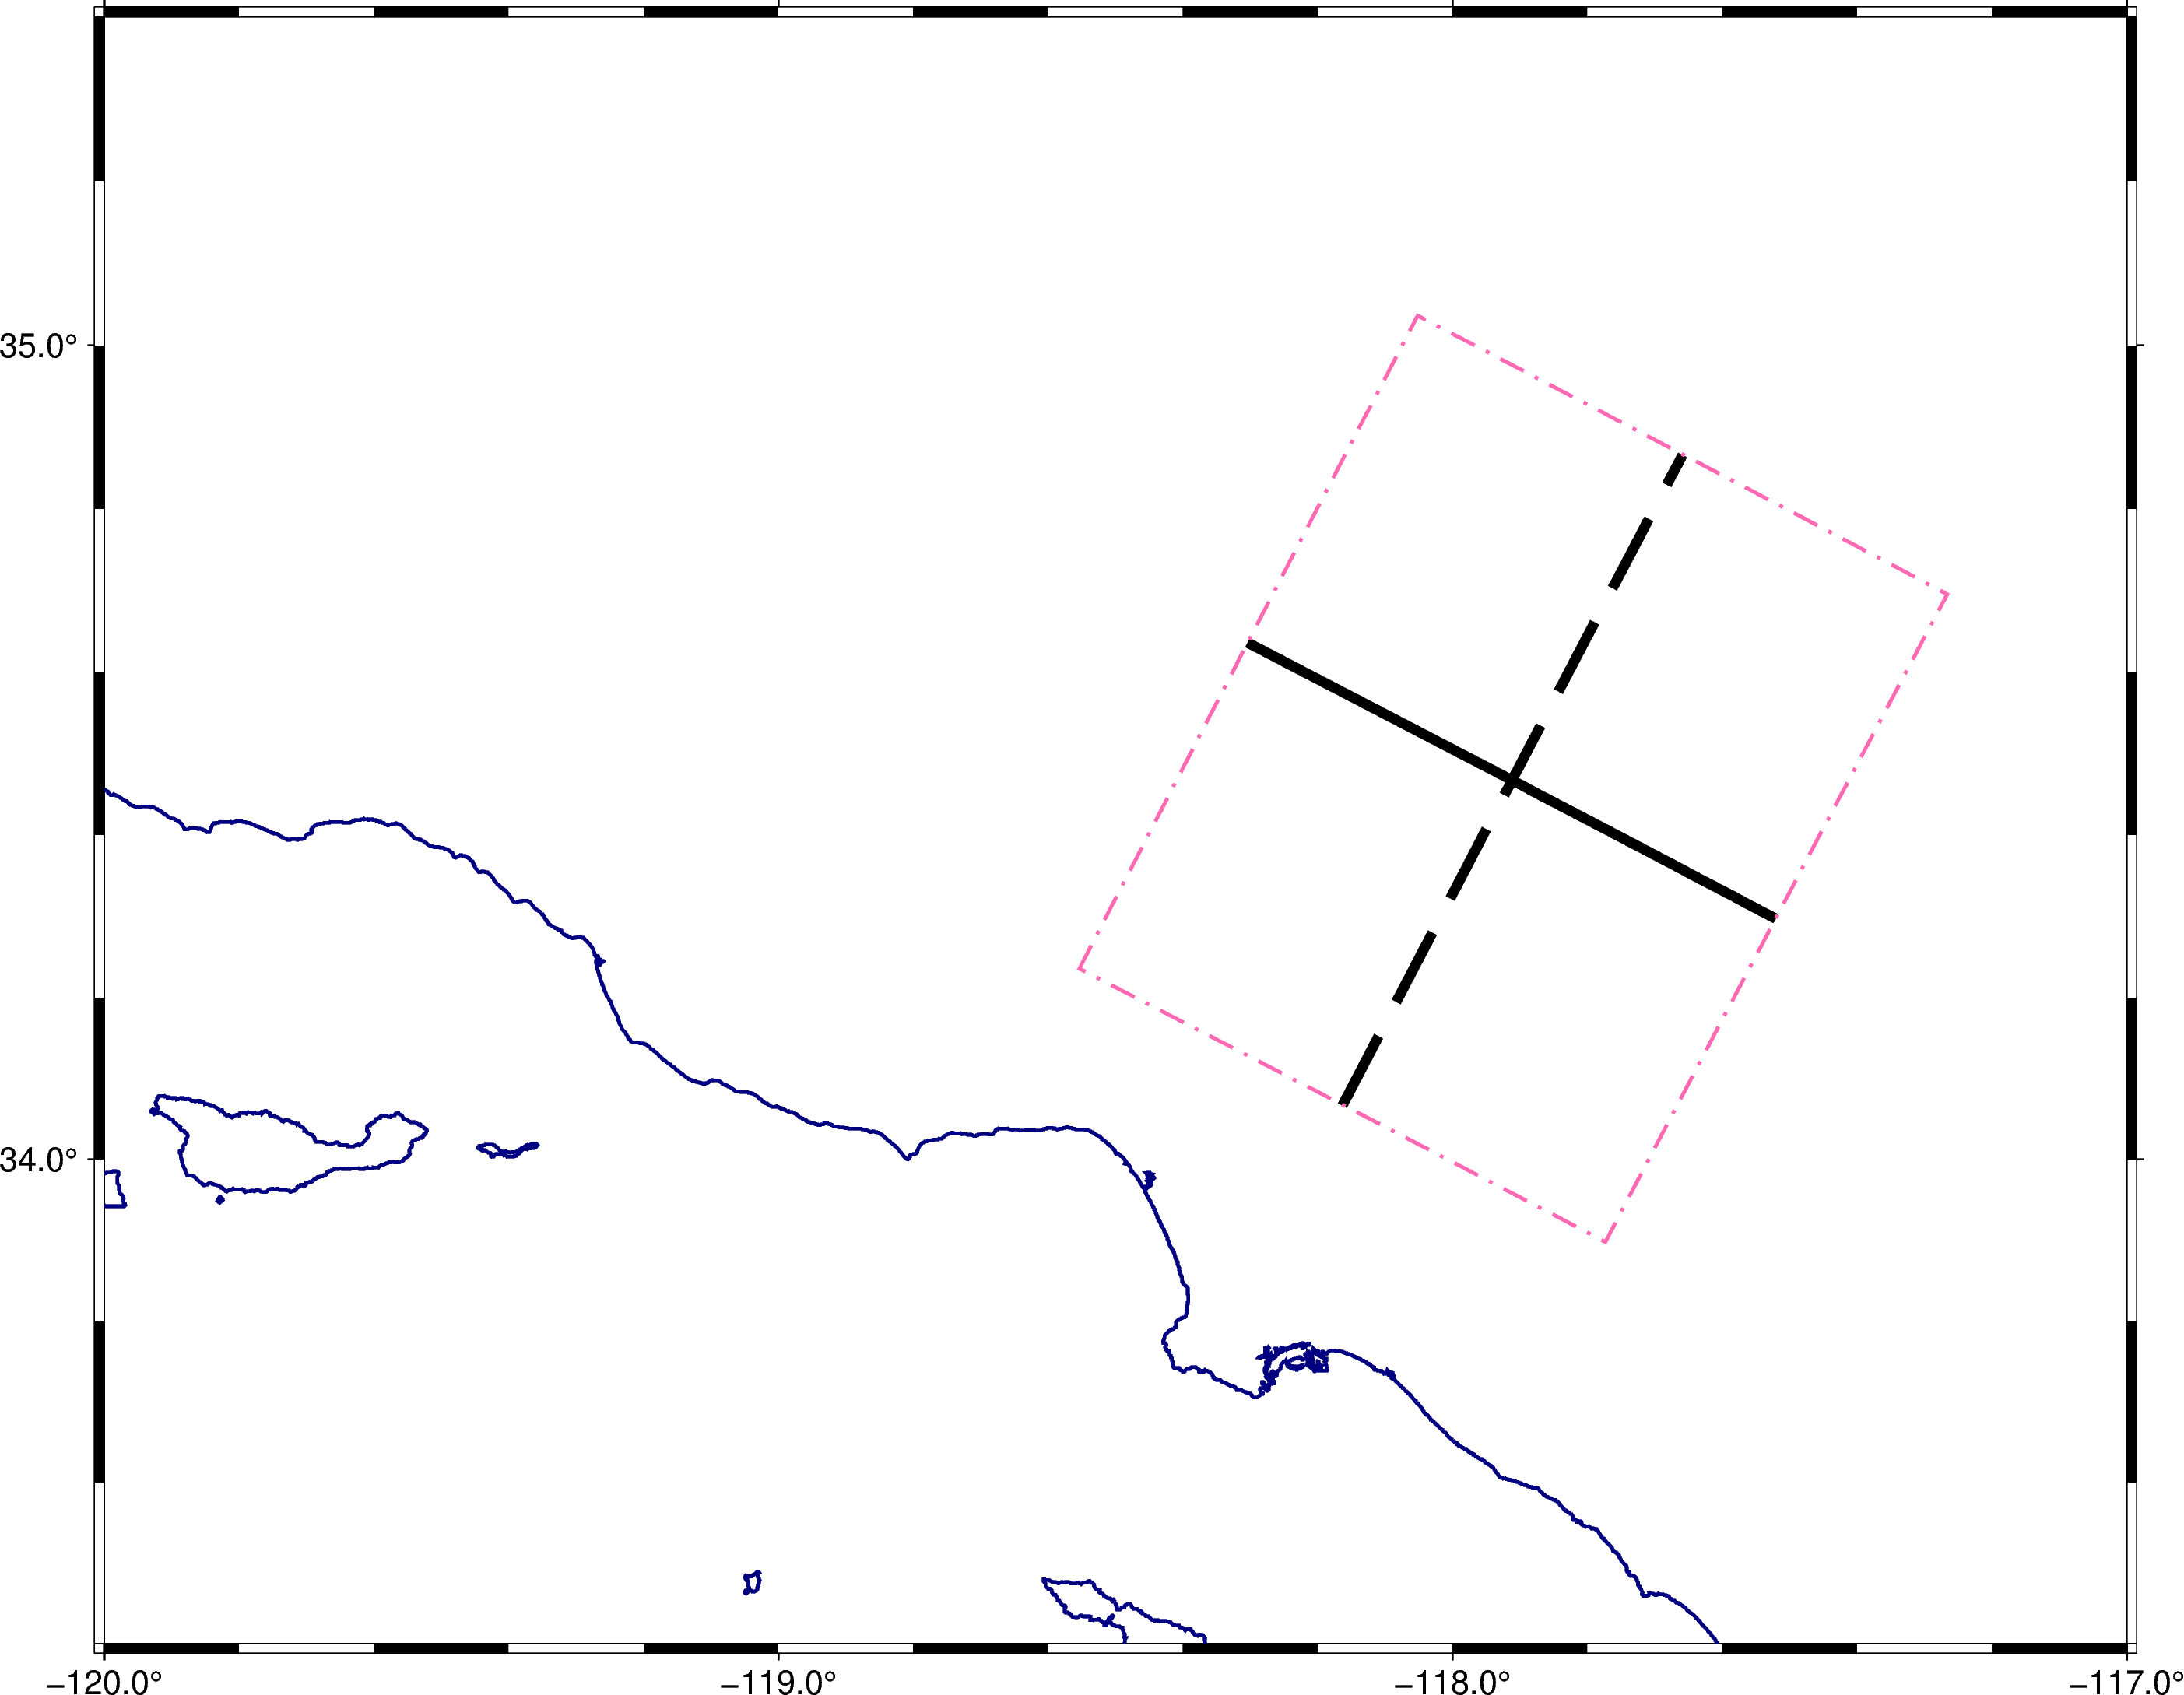

In [11]:
# let's plot some lines on a map!

# set up a bounding box
study_region=[-120,-117,33.4,35.4]  # [west, east, south, north]

# initiate a PyGMT figure 
fig = pygmt.Figure() 

# override some ugly (I think) defaults:
pygmt.config(FORMAT_GEO_MAP="ddd.x")

# make a basemap frame
fig.basemap(region=study_region, projection="M22c", frame=["a1f0.2","WeSn"]) 

# plot coasts in navy blue and national borders in dark red
fig.coast(shorelines=["1/1p,navy","2/1p,navy"], borders=["1/0.5p,darkred"]) 

# plot the fault trace and profile line
fig.plot(fault_vertices_ll, pen="3p,black")
fig.plot(prof_vertices_ll,pen="3p,black,-")

# plot the earthquakes as little black circles
#fig.plot(eq_data[:,8],eq_data[:,7],style="c0.05c",color="black")

# plot the boxes!
fig.plot(x=box_vertices_ll[1],y=box_vertices_ll[0], pen="1p,hotpink,-.",close=True)

# and display!
fig.show()


Look good? Then we shall proceed with data selection! We can use the 'gmt select' terminal command to do this.

In [12]:
# save the box vertices in a text file
# (there is a bit of messing around to get the box vertices into a numpy array before saving it)
np.savetxt('box_vertices.txt',np.transpose(np.array([box_vertices_ll[1],box_vertices_ll[0]])))

# use gmt to select the points from our GNSS data file that are in our box
# numpy isn't going to like the station names, so we'll awk them out
!/home/jupyter-jddianala/.conda/envs/ecd2023/bin/gmt select cwu.snaps_nam14.velo -Fbox_vertices.txt -JM22c | awk '{print $1, $2, $3, $4, $5, $6, $7}' > selected_gnss.velo

You can look at the contents and verify that there are not very many stations left:

In [13]:
!cat selected_gnss.velo

242.103512066 34.1260187883 -24.15 22.23 0.2 0.18 0
241.722949076 34.184894724 -24.78 24.52 0.39 0.09 0
241.811772493 34.2928064362 -23.38 22.57 0.12 0.17 0
242.035053229 34.2439932363 -22.87 21.62 0.28 0.39 0
241.974000013 34.3334230068 -22.33 21.93 0.07 0.05 0
242.172298023 34.6404623069 -11.84 15.15 0.2 0.16 0
241.872713869 34.1367088441 -24.11 23.5 0.22 0.17 0
241.855768965 34.5303222987 -18.53 21.1 0.22 0.18 0
242.291189523 34.1099283714 -22.78 22.35 0.09 0.19 0
241.588574681 34.3531801428 -24.58 24.04 0.32 0.56 0
241.476187323 34.2535503402 -25.3 27.01 0.12 0.24 0
242.098281502 34.0820116042 -24.85 23.3 0.56 0.22 0
241.603134993 34.3348357789 -24.32 23.58 0.26 0.15 0
241.602531253 34.3339917362 -26.44 23.13 0.2 0.11 0
242.139870973 34.4134131152 -19.21 19.73 0.1 0.08 0
241.759499357 34.7339131138 -13.45 17.71 0.14 0.13 0
241.887104913 34.0474473743 -25.42 24.1 0.17 0.1 0
242.200545716 34.7599202028 -10.8 15.34 0.14 0.08 0
242.154872366 34.4581555557 -16.89 18.39 0.14 0.06 0
242.1

Now that we have selected some sites, we can read in the file, and do the rest of the analysis in this splendid Jupyter notebook environment...

In [14]:
# read in the data, which, if it's all numerical, is easy to do with the numpy 'loadtxt' command
selected_gnss=np.loadtxt('selected_gnss.velo')

If we did this right, we should have loaded in the columns of the 'selected_gnss.velo' file as columns of a numpy array called 'selected_gnss', which you can verify if you want to...

In [15]:
selected_gnss[0:5,:]

array([[ 2.42103512e+02,  3.41260188e+01, -2.41500000e+01,
         2.22300000e+01,  2.00000000e-01,  1.80000000e-01,
         0.00000000e+00],
       [ 2.41722949e+02,  3.41848947e+01, -2.47800000e+01,
         2.45200000e+01,  3.90000000e-01,  9.00000000e-02,
         0.00000000e+00],
       [ 2.41811772e+02,  3.42928064e+01, -2.33800000e+01,
         2.25700000e+01,  1.20000000e-01,  1.70000000e-01,
         0.00000000e+00],
       [ 2.42035053e+02,  3.42439932e+01, -2.28700000e+01,
         2.16200000e+01,  2.80000000e-01,  3.90000000e-01,
         0.00000000e+00],
       [ 2.41974000e+02,  3.43334230e+01, -2.23300000e+01,
         2.19300000e+01,  7.00000000e-02,  5.00000000e-02,
         0.00000000e+00]])

Just to be sure, let's try plotting these stations on a map. If everything worked like it was supposed to, then all of the GNSS stations' locations should plot within our box. Fingers crossed...

/tmp/ipykernel_680655/961490388.py:18: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x=selected_gnss[:,0], y=selected_gnss[:,1], style="i0.7c", color="red", pen="0.5p,black")


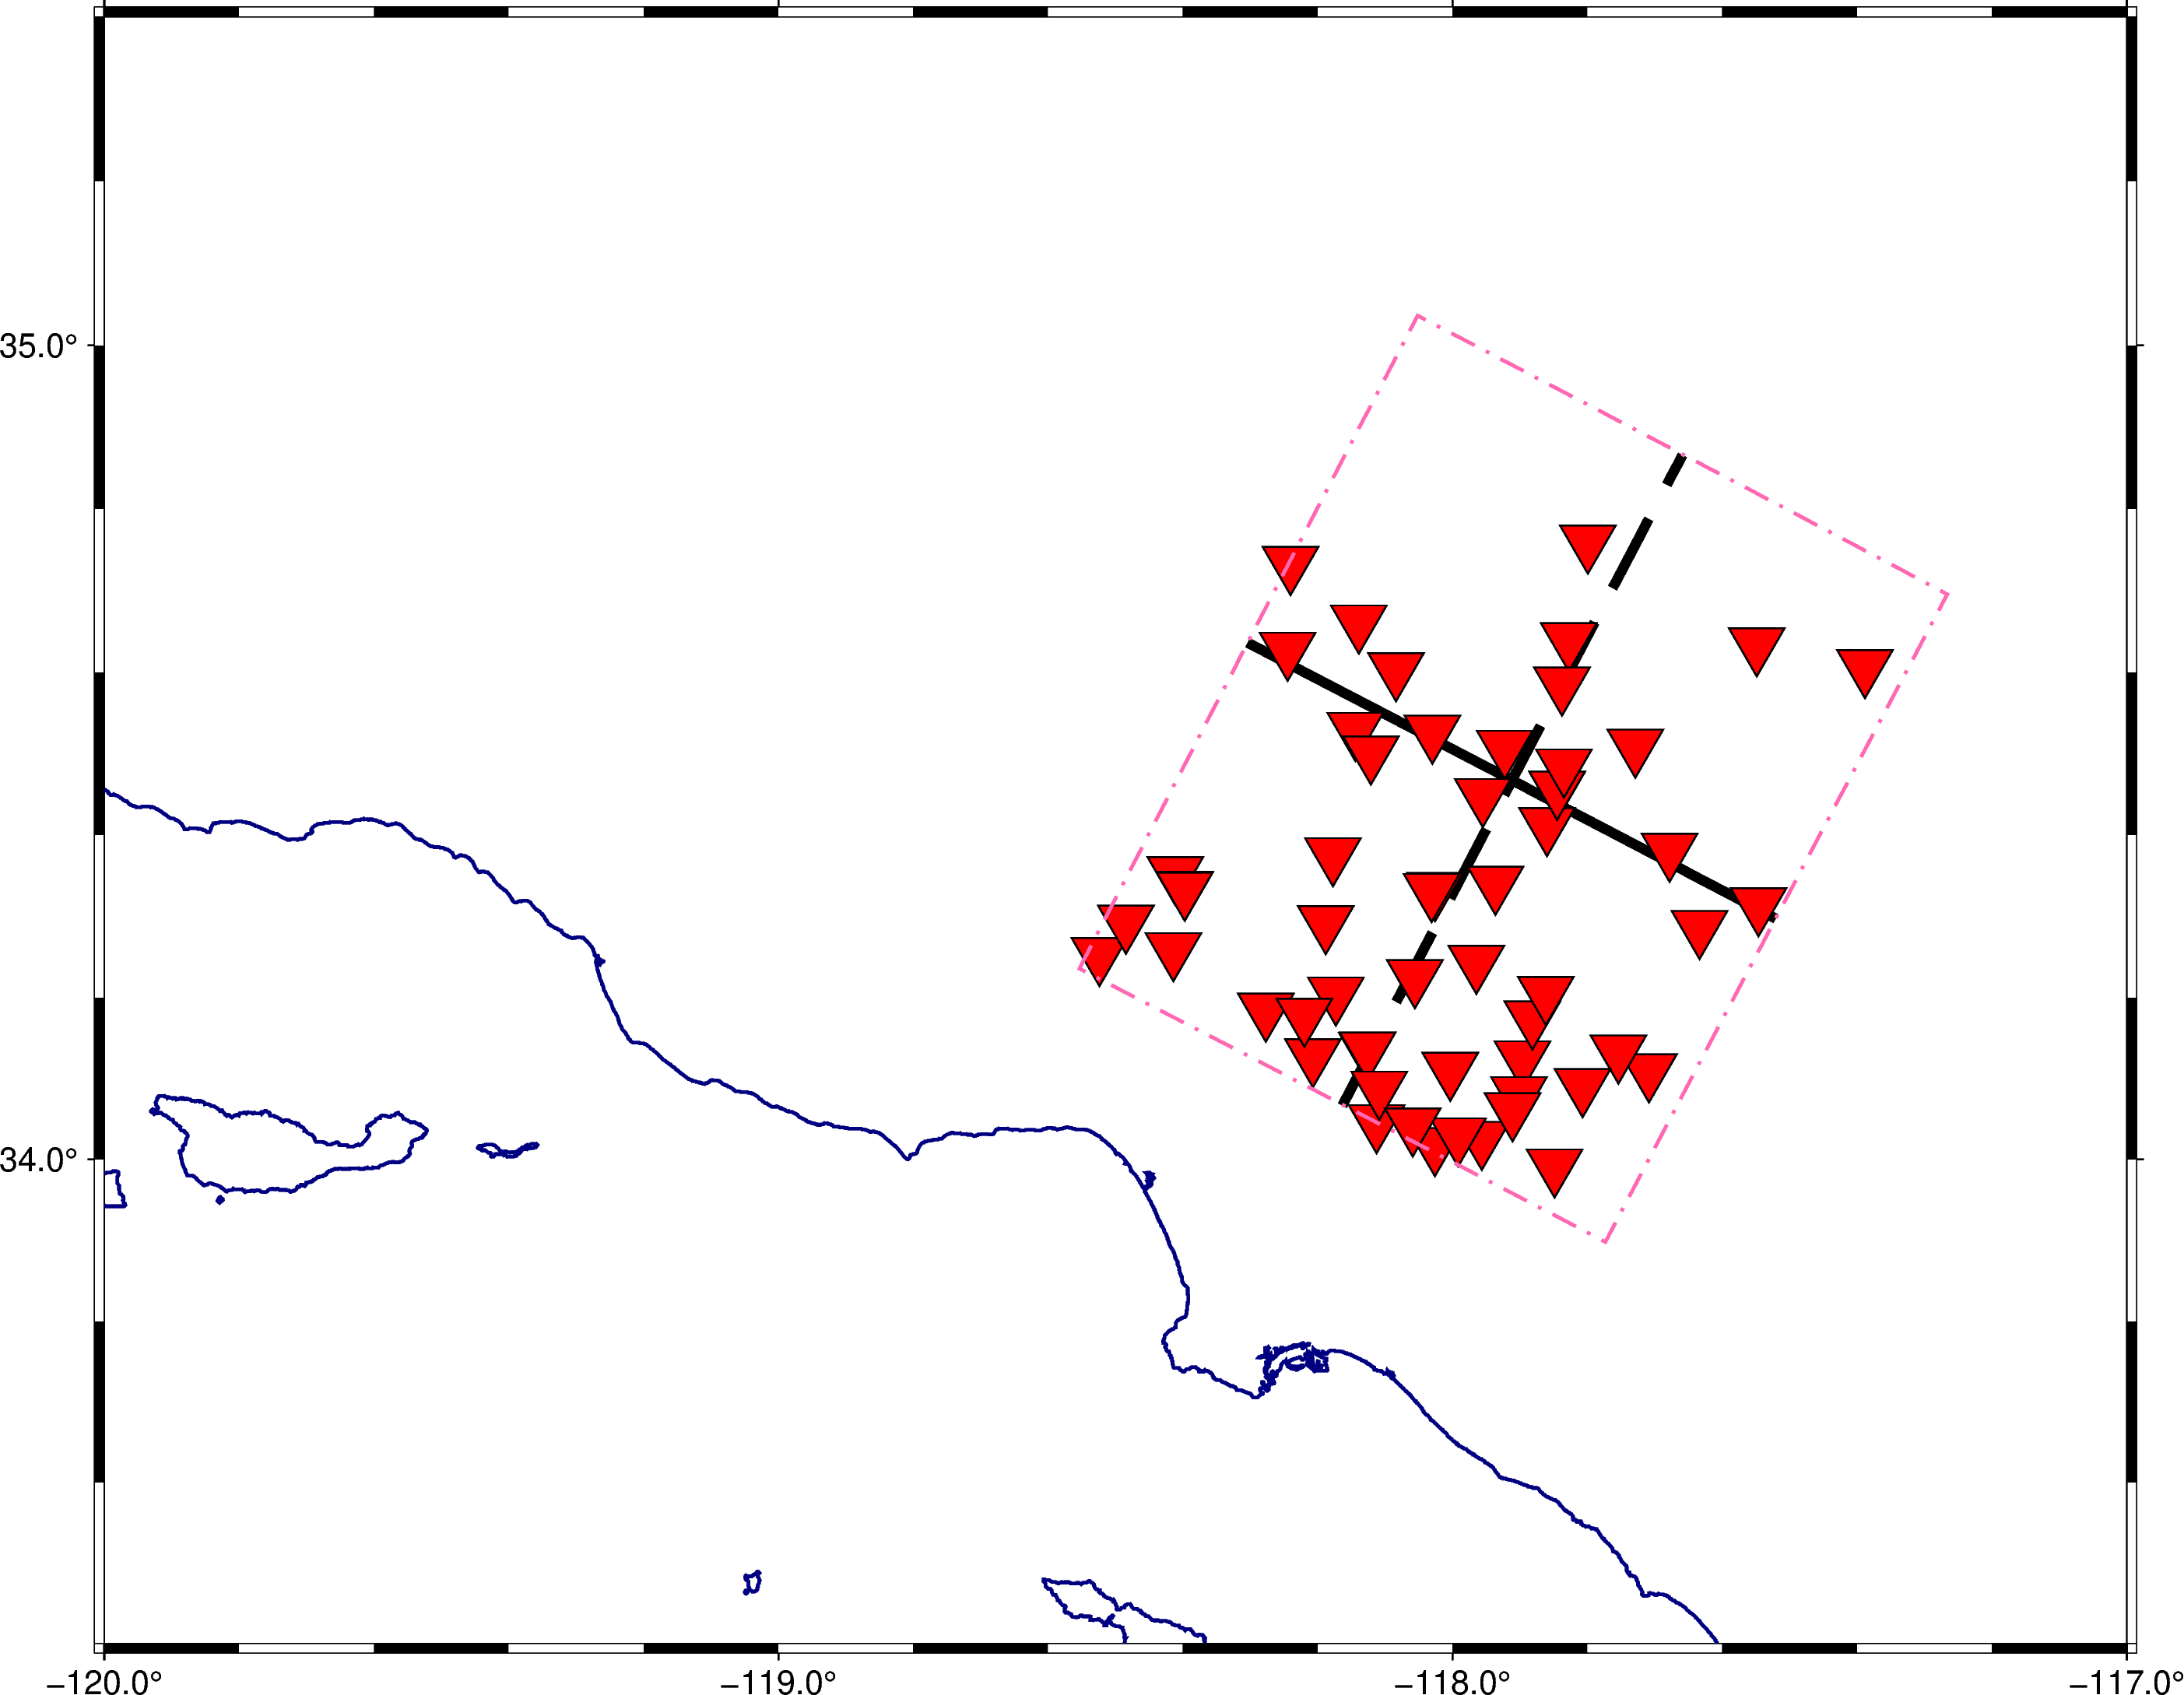

In [16]:
# initiate a PyGMT figure 
fig = pygmt.Figure() 

# override some ugly (I think) defaults:
pygmt.config(FORMAT_GEO_MAP="ddd.x")

# make a basemap frame
fig.basemap(region=study_region, projection="M22c", frame=["a1f0.2","WeSn"]) 

# plot coasts in navy blue and national borders in dark red
fig.coast(shorelines=["1/1p,navy","2/1p,navy"], borders=["1/0.5p,darkred"]) 

# plot the fault trace and profile line
fig.plot(x=fault_vertices_ll[:,0], y=fault_vertices_ll[:,1], pen="3p,black")
fig.plot(x=prof_vertices_ll[:,0], y=prof_vertices_ll[:,1], pen="3p,black,-")

# THE NEW BIT! plot all of the stations as red inverted triangles
fig.plot(x=selected_gnss[:,0], y=selected_gnss[:,1], style="i0.7c", color="red", pen="0.5p,black")

# plot the box!
fig.plot(x=box_vertices_ll[1], y=box_vertices_ll[0], pen="1p,hotpink,-.",close=True)

# and display!
fig.show()


Success! (I hope!) If you want to try something a little bit extra, how about loading in and plotting all of the GNSS stations (maybe a different color?), just to see what else we might be missing?

## 3. Projecting GNSS stations onto a profile

The previous station ended on a somewhat euphoric note, with GNSS stations around our fault of interest selected and loaded into Python. Phew! The rest of our exercise can be completed entirely within Python, without the need for messing around with text files (hopefully one day PyGMT will include the 'select' functionality...)

Our next task is to project the GNSS station locations onto a profile. This is a straightforward application of the scalar product of two vectors, one being the position of the station with respect to the profile origin, and the other being the unit vector in the profile direction:

In [17]:
# first let's convert the GNSS station coordinates into utm
# (if we get a 'longitude out of range error', we should subtract 360 from the longitude)
selected_gnss_utm=utm.from_latlon(selected_gnss[:,1],selected_gnss[:,0]-360,utm_zone,utm_lett)

# find the profile origin (the middle of the box!)
profile_origin_utm=np.array([np.mean(prof_vertices_utm[:,0]),np.mean(prof_vertices_utm[:,1])])

# and find the position of the stations with respect to it!
gnss_position=np.transpose(np.vstack((selected_gnss_utm[0],selected_gnss_utm[1])))-profile_origin_utm

# finally, let's assemble the unit profile vector
prof_uv = np.array([prof_dx,prof_dy])

All that remains is to figure out how to take the dot product of the rows of the 'gnss_position' array with the unit pointing vector 'prof_uv'...

In [18]:
# calculate the dot product between the position vector and the unit profile vector
x_data = gnss_position.dot(prof_uv)/1000

And, after dividing by 1000, we have along-profile distances in km!

## 4. Project GNSS velocities into the fault-parallel direction

The next trick will be to do the same thing, with a unit fault-parallel vector, with the velocities, to estimate the fault-parallel component of the GNSS velocities.

In [19]:
# unit vector for fault-parallel direction
fault_uv=np.array([fault_dx,fault_dy])

# calculate the dot product of the velocities with the unit vector to get fault-parallel velocity
v_data=selected_gnss[:,[2,3]].dot(fault_uv)

# combine the errors from the north and east components to get the error in fault-parallel velocity
# (this formulation assumes the errors are independent, which they are for the CWU NOTA velocities)
v_err=np.sqrt((selected_gnss[:,4]*fault_uv[0])**2+(selected_gnss[:,5]*fault_uv[1])**2)


Let's make sure that this all worked, by plotting the two things we have just calculated against each other... velocity against distance. If we did it right, and the San Andreas fault is behaving, we ought to see something like an arctangent. In this case, a quick matplotlib plot is appropriate:

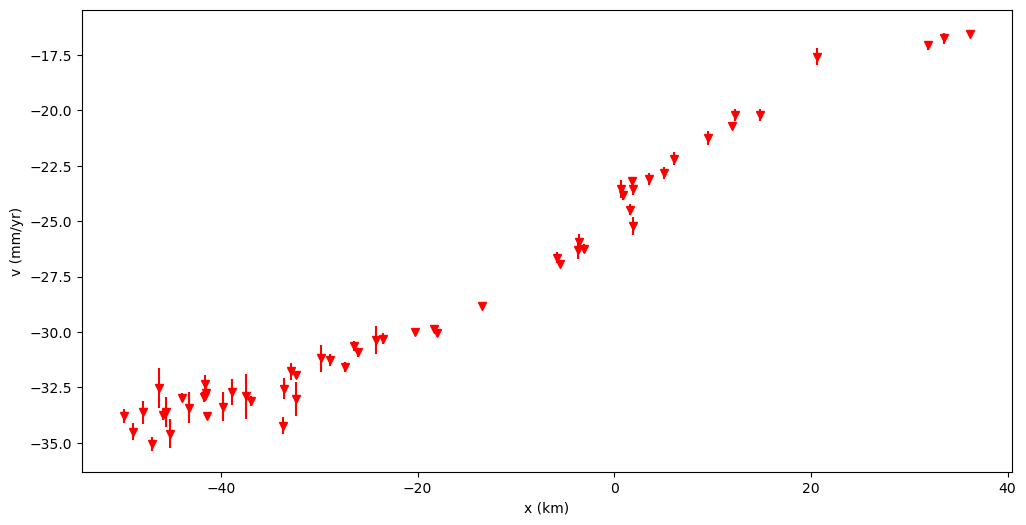

In [20]:
# initiate the plot
plt.figure(figsize=(12,6))

# plot the data as red inverted triangles with 2-sigma error bars
plt.errorbar(x_data, v_data, yerr=2*v_err, fmt="rv")  
    
# add some labels
plt.xlabel("x (km)")
plt.ylabel("v (mm/yr)")

plt.show()

I think this is a success! Note that this is plotted with error bars, but it is pretty hard to tell $-$ the errors in velocities for continuous GNSS stations can be very small!

## 5. Forward, 'trial-and-error' models

The simplest way to try and fit data like these is by pure manual experimentation. This is not the most objective method, but can allow you to build some intuition about what sorts of models might fit the data.

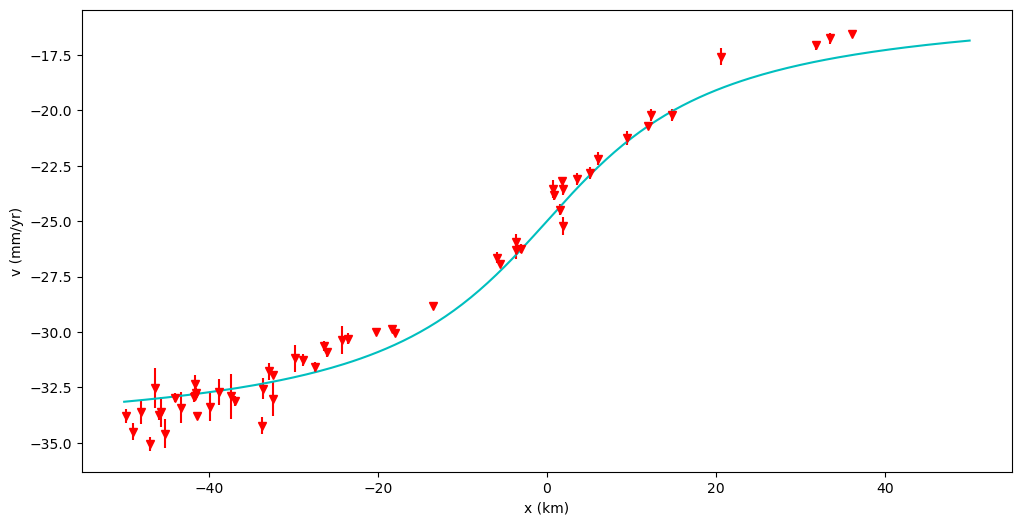

In [21]:
s = 20
D = 15
v_shift = -25
point_spacing = 0.5

# values of x for calculating the model
half_points = round(half_length/point_spacing) # how many points along each half of the profile?
x = np.linspace(-half_length,half_length,1+2*half_points)

# calculate your forward model, with additional shift
v = (s/np.pi)*np.arctan(x/D)+v_shift

# plotting!
plt.figure(figsize=(12,6))

plt.errorbar(x_data, v_data, yerr=2*v_err, fmt="rv")   # plot it as a line of width 3, label with the locking depth
plt.plot(x,v,"c-")

# add some labels
plt.xlabel("x (km)")
plt.ylabel("v (mm/yr)")

plt.show()

In [22]:
# to assess the fit of the data, we can evaluate a penalty function: the WRSS penalty
# (weighted residual sum of squares)

# evaluate the model at the locations of our stations
v_forward=(s/np.pi)*np.arctan(x_data/D)+v_shift

# the penalty function is calculated by two matrix multiplications
WRSS = np.matmul(np.matmul((v_data-v_forward),np.diag(v_err**2)),(v_data-v_forward).T) 

print('WRSS penalty: {0:6.3f} (mm/yr)^2'.format(WRSS))

WRSS penalty:  1.429 (mm/yr)^2


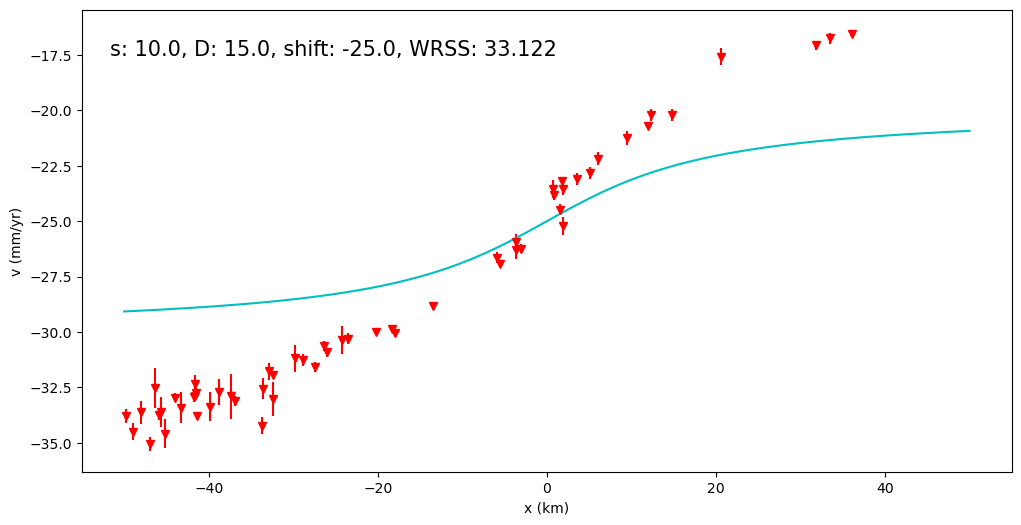

In [25]:
# ok, let's put all of these things in a single cell

# model parameters
s = 10
D = 15
v_shift = -25

# calculate your forward model, with additional shift, at the station locations for evaluating misfit
v_forward=(s/np.pi)*np.arctan(x_data/D)+v_shift

# calculate the penalty
WRSS=np.matmul(np.matmul((v_data-v_forward),np.diag(v_err**2)),(v_data-v_forward).T) 

# calculate your forward model, with additional shift, for plotting purposes
v = (s/np.pi)*np.arctan(x/D)+v_shift

# plotting!
plt.figure(figsize=(12,6))
plt.errorbar(x_data, v_data, yerr=2*v_err, fmt="rv")   # data with 2-sigma error bars
plt.plot(x,v,"c-")                                     # forward model

# add some labels
plt.xlabel("x (km)")
plt.ylabel("v (mm/yr)")
plt.text(0.03, 0.9, 's: {0:4.1f}, D: {1:4.1f}, shift: {2:4.1f}, WRSS: {3:5.3f}'.format(s,D,v_shift,WRSS), 
         size=15, transform=plt.gca().transAxes)

plt.show()

Have a play around, changing the parameters, and see how low you can get the WRSS penalty. Record your best penalty values below:

In [27]:
# best trial-and-error model parameters
s_best = 33
D_best = 14
v_shift_best = -29.5

# and the corresponding best penalty
v_best=(s_best/np.pi)*np.arctan(x_data/D_best)+v_shift_best
WRSS_best=np.matmul(np.matmul((v_data-v_best),np.diag(v_err**2)),(v_data-v_best).T) 

## 6. Using a grid search to identify a preferred model

Of course, we don't have to do everything by trial and error! One way that we can approach this problem is by systematically evaluating different combinations of slip rate and locking depth via a 'grid search'. In a grid search, we define _a priori_ ranges of the parameters to test, evaluate each combination of them, and look for the lowest value of the penalty, which corresponds to the preferred set of model parameters.

In [36]:
# OK, let's run a grid search!

# model parameters
s_min = 10  # lowest slip rate
s_max = 50  # highest slip rate
s_step = 0.5  # slip rate increment

D_min = 2  # shallowest locking depth
D_max = 50  # deepest locking depth
D_step = 0.5  # locking depth increment

# set up the parameter value ranges
n_s = round(1+(s_max-s_min)/s_step)
s_set = np.linspace(s_min,s_max,n_s)
n_D = round(1+(D_max-D_min)/D_step)
D_set = np.linspace(D_min,D_max,n_D)

# set up arrays for the results
sv, Dv = np.meshgrid(s_set,D_set)
WRSS=np.zeros((np.shape(sv)))

# and loop!
for i in range(n_D):
    for j in range(n_s):
        v_forward=(sv[i,j]/np.pi)*np.arctan(x_data/Dv[i,j])
        v_shift=np.mean(v_data-v_forward)
        WRSS[i,j]=np.matmul(np.matmul((v_data-v_forward-v_shift),np.diag(v_err**2)),(v_data-v_forward-v_shift).T) 
        

In [37]:
# what was the best model?
WRSS_best=np.amin(WRSS)                # find minimum value of WRSS
best_model=np.where(WRSS==WRSS_best)   # find the index for the minimum WRSS model

s_best=sv[best_model].item()           # use index to find best value of s...
D_best=Dv[best_model].item()           # ...and of D

v_best=(s_best/np.pi)*np.arctan(x_data/D_best)
v_shift_best=np.mean(v_data-v_best)    # best velocity shift for those values of s and D

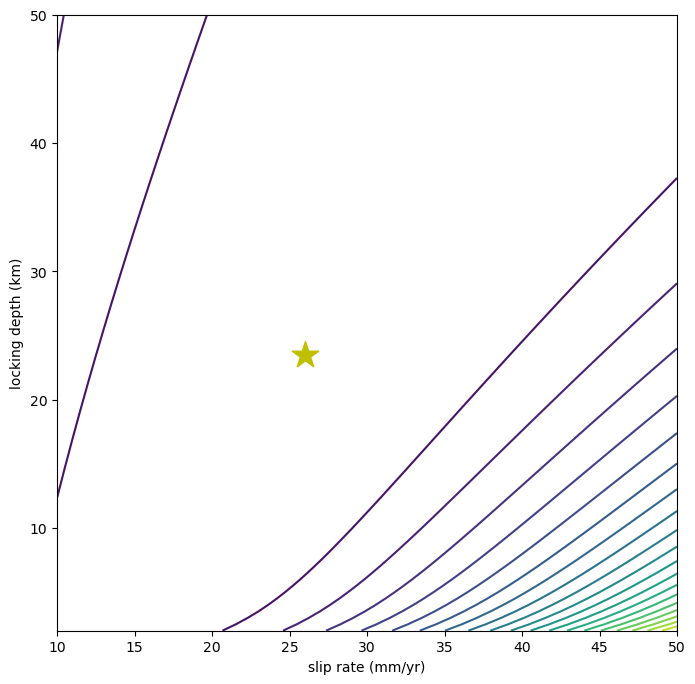

In [38]:
# make a contour plot?

plt.figure(figsize=(8,8))
plt.contour(sv,Dv,WRSS,20)
plt.scatter(s_best,D_best,s=400,c='y',marker='*')    # plot a big yellow star at the location of the best model

plt.xlabel("slip rate (mm/yr)")
plt.ylabel("locking depth (km)")

plt.show()

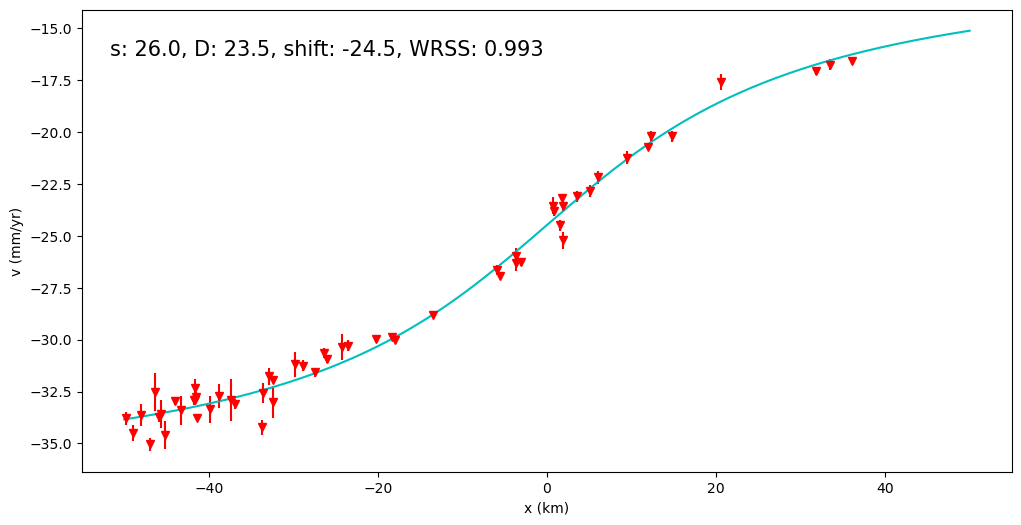

In [39]:
# calculate your best model, with additional shift, for plotting purposes
v = (s_best/np.pi)*np.arctan(x/D_best)+v_shift_best

# plotting!
plt.figure(figsize=(12,6))
plt.errorbar(x_data, v_data, yerr=2*v_err, fmt="rv")   # data with 2-sigma error bars
plt.plot(x,v,"c-")                                     # forward model

# add some labels
plt.xlabel("x (km)")
plt.ylabel("v (mm/yr)")
plt.text(0.03, 0.9, 's: {0:4.1f}, D: {1:4.1f}, shift: {2:4.1f}, WRSS: {3:5.3f}'.format(s_best,D_best,v_shift_best,WRSS_best), 
         size=15, transform=plt.gca().transAxes)

plt.show()